In [1]:
# Display plots in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pylab as pl
import pandas as pd
import geopandas as gp
import ast
import json
import urllib
import urllib2
import fiona
import statsmodels.formula.api as smf
import sklearn
import sklearn.cluster
from fiona import crs
from cStringIO import StringIO
from scipy.cluster import vq

# Make plots prettyful
pl.style.use('fivethirtyeight')

# Seed random
np.random.seed(123)

In [3]:
# Query Function from Data notebook
SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
# Get zipcodes from DB
query = 'select * from nyc_zipcode_highway'# LIMIT 5'
zipcodes_json = json.loads(queryCartoDB(query, format='GeoJSON').read())
zipcodes = gp.GeoDataFrame.from_features(zipcodes_json['features'])
zipcodes.crs = crs.from_epsg(4326)
zipcodes = zipcodes.to_crs(epsg=2263)

# Task 1

In [5]:
# Query for the top facilities and the number of cases
query = '''
SELECT f.*, s.count 
FROM nyc_facilities f
INNER JOIN
    (select facility_id, COUNT(*) as count from nyc_discharge_2013 d
    WHERE 
        lower(d.ccs_diagnosis_description) LIKE '%asthma'
    GROUP BY d.facility_id
    ORDER BY COUNT(*) DESC
    LIMIT 5) s
ON (f.facility_id = s.facility_id)
'''
# Run Query
res = json.loads(queryCartoDB(query, format='GeoJSON').read())
top_facilities = gp.GeoDataFrame.from_features(res['features'])

# Convert to 2263
top_facilities.crs = crs.from_epsg(4326)
top_facilities = top_facilities.to_crs(epsg=2263)

# Create circles for plotting
top_facilities['geometry'] = top_facilities.geometry.buffer(3000)

In [6]:
# Top 5 facilities in order
top_facilities.sort('count',ascending=False)[['facility_name', 'count']]

,facility_name,count
2,Lincoln Medical & Mental Health Center,1878
1,Montefiore Medical Center - Henry & Lucy Moses...,1786
4,Kings County Hospital Center,1057
0,Jacobi Medical Center,920
3,Bronx-Lebanon Hospital Center - Concourse Divi...,890


(900000.0, 1080000.0, 120000.0, 280000.0)

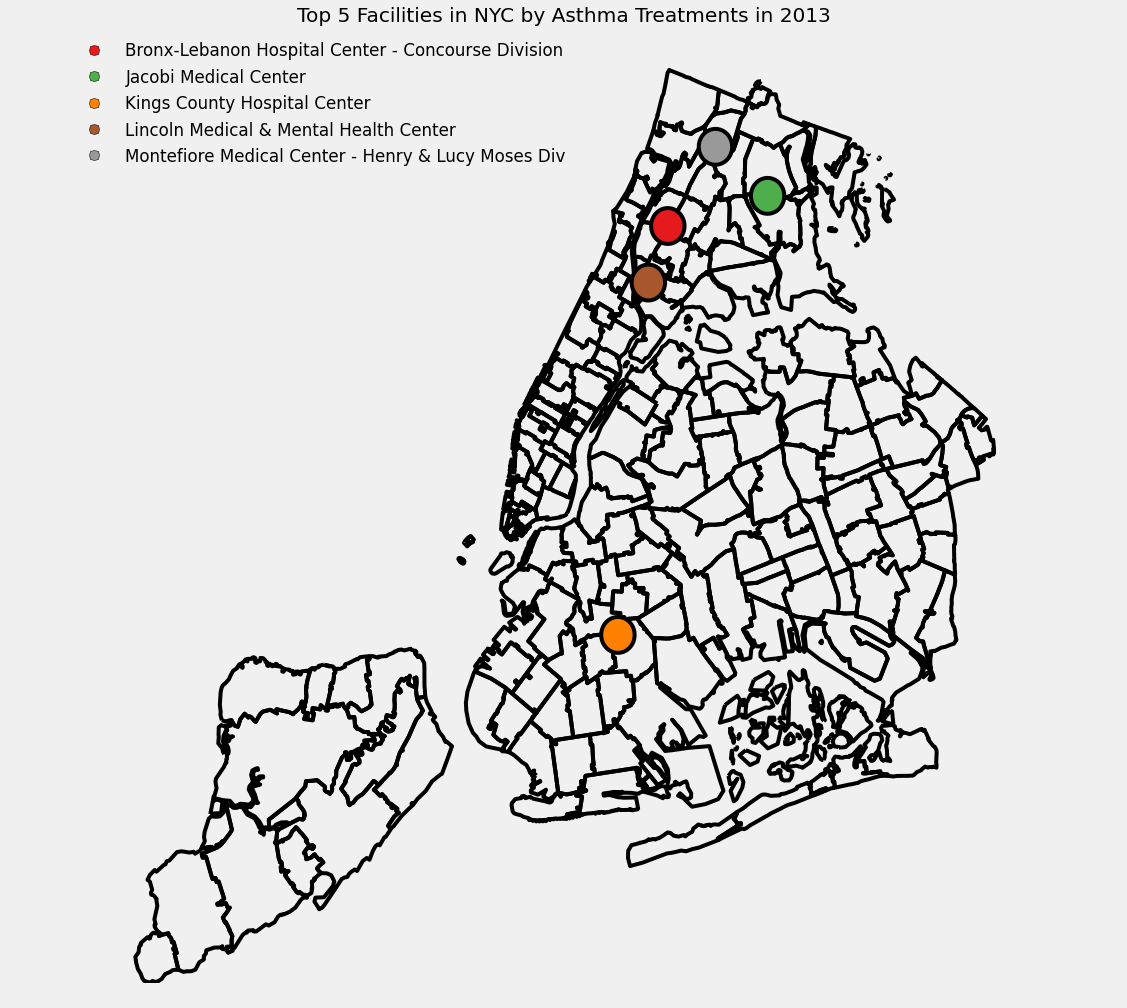

In [7]:
# Plot
figure, ax = pl.subplots(figsize=(16,16))

# Plot on separate axes.  For some reason I couldn't get the circles to show up
# above the zip codes any other way.
ax2 = ax.twinx()

# Plot
top_facilities.plot(axes=ax2, column='facility_name', categorical=True, legend=True, alpha=1)
zipcodes.plot(axes=ax, alpha=0)

# Fix scale
ax2.set_ylim(ax.get_ylim())

# Title and remove grid lines
ax.set_title('Top 5 Facilities in NYC by Asthma Treatments in 2013')
ax.axis('off')
ax2.axis('off')

The locations of the 5 facilities in NYC to have the most asthma patients in 2013 overlayed on the zipcode boundries.

# Task 2

In [8]:
# Query, joining on the highway table
query = '''
SELECT f.*, z.zipcode, z.highway_length, s.count 
FROM nyc_facilities f
INNER JOIN
    (select facility_id, COUNT(*) as count from nyc_discharge_2013 d
    WHERE 
        lower(d.ccs_diagnosis_description) LIKE '%asthma'
    GROUP BY d.facility_id
    ORDER BY COUNT(*) DESC
    LIMIT 5) s
ON (f.facility_id = s.facility_id)
INNER JOIN
    nyc_zipcode_highway z
ON ST_CONTAINS(z.the_geom, f.the_geom)
'''
# Query
res = json.loads(queryCartoDB(query, format='GeoJSON').read())
top_facilities = gp.GeoDataFrame.from_features(res['features'])

# Convert to 2263
top_facilities.crs = crs.from_epsg(4326)
top_facilities = top_facilities.to_crs(epsg=2263)

# Create circles for plotting
top_facilities['geometry'] = top_facilities.geometry.buffer(3000)

In [9]:
# Top 5 facilities in order
top_facilities.sort('count',ascending=False)[['facility_name', 'count', 'zipcode', 'highway_length']]

,facility_name,count,zipcode,highway_length
2,Lincoln Medical & Mental Health Center,1878,10451,7.914185
1,Montefiore Medical Center - Henry & Lucy Moses...,1786,10467,19.172015
4,Kings County Hospital Center,1057,11203,2.212840
0,Jacobi Medical Center,920,10461,18.102258
3,Bronx-Lebanon Hospital Center - Concourse Divi...,890,10457,5.017199


(900000.0, 1080000.0, 120000.0, 280000.0)

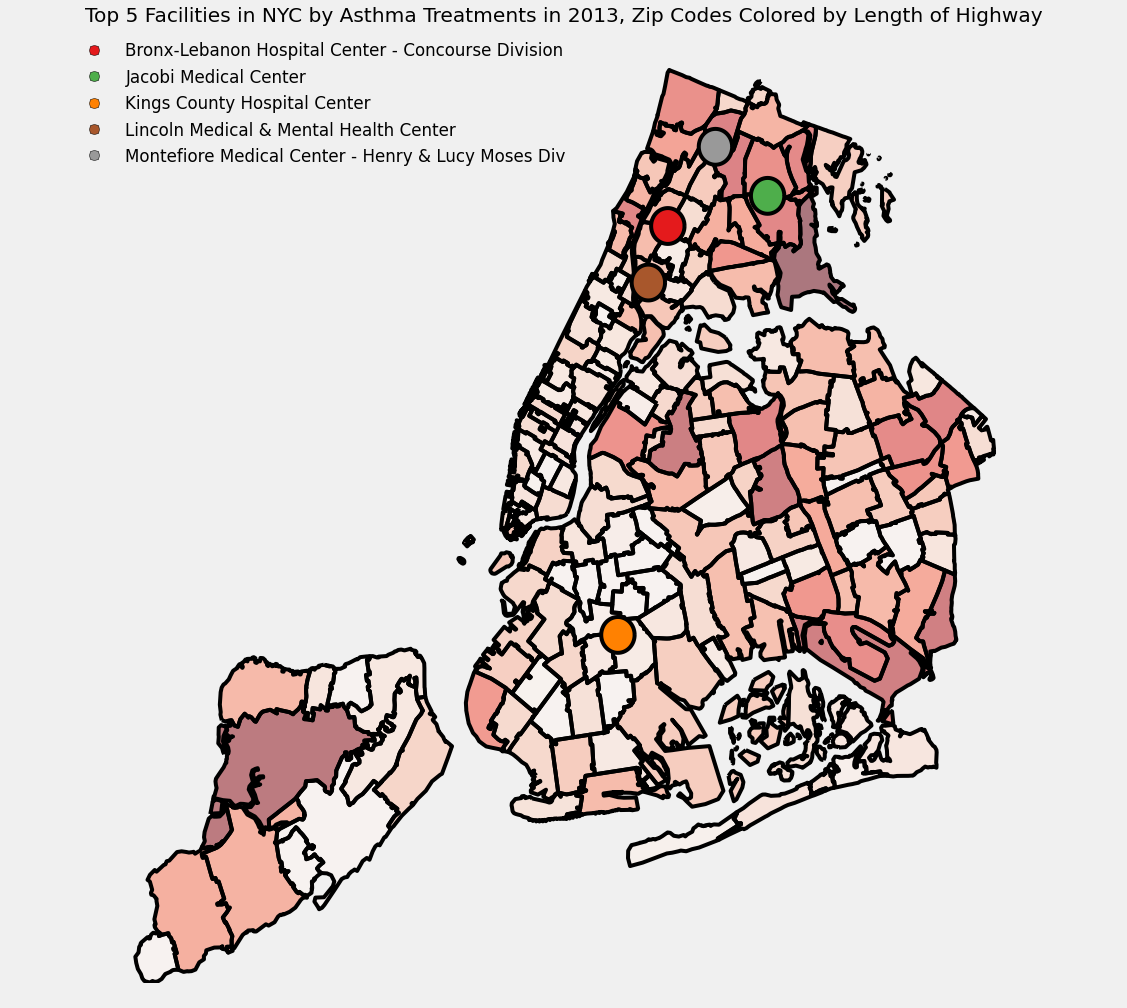

In [10]:
# Plot
figure, ax = pl.subplots(figsize=(16,16))

# Plot on separate axes.  For some reason I couldn't get the circles to show up
# above the zip codes any other way.
ax2 = ax.twinx()

# Plot
top_facilities.plot(axes=ax2, column='facility_name', categorical=True, legend=True, alpha=1)
zipcodes.plot(axes=ax, column='highway_length',colormap='Reds')

# Fix scale
ax2.set_ylim(ax.get_ylim())

# Title and remove grid lines
ax.set_title('Top 5 Facilities in NYC by Asthma Treatments in 2013, Zip Codes Colored by Length of Highway')
ax.axis('off')
ax2.axis('off')

The locations of the 5 facilities in NYC to have the most asthma patients in 2013.  Zipcodes are colored from white to red based on the length of highway contained and whithin .25 miles of the zipcode.

# Task 5

In [11]:
# Pull pre-processed CSV from internet.
# Pre-processed to avoid downloading massive 311 dataset while this
# notebook is running.

# CSV has total number of complaints and number of asthma
# related complaints for each zip code for 2010-2013 and the ratio
# of asthma related to the total.

complaints = pd.read_csv("http://jeremyneiman.com/projects/files/311_processed.csv")
complaints.head(5)

,2010_a,zip,2011_a,2012_a,2013_a,2010_s,2011_s,2012_s,2013_s,2010_r,2011_r,2012_r,2013_r,total_a,total_s,total_r
0,6813,10001,6201,5867,6841,354,391,395,749,0.051959,0.063054,0.067326,0.109487,25722,1889,0.073439
1,12727,10002,11372,10834,11328,650,586,633,661,0.051073,0.051530,0.058427,0.058351,46261,2530,0.054690
2,11868,10003,11191,10703,11286,770,733,672,820,0.064880,0.065499,0.062786,0.072656,45048,2995,0.066485
3,1323,10004,1344,1488,1541,96,91,97,173,0.072562,0.067708,0.065188,0.112265,5696,457,0.080232
4,1224,10005,1400,1693,1832,105,170,222,355,0.085784,0.121429,0.131128,0.193777,6149,852,0.138559


In [12]:
top311 = top_facilities.merge(complaints, left_on='zipcode', right_on='zip')

In [13]:
top311.sort('count',ascending=False)[[
    'facility_name', 'count', 'zipcode', 'highway_length', 
    '2010_r', '2011_r', '2012_r', '2013_r', 'total_r'
]]

,facility_name,count,zipcode,highway_length,2010_r,2011_r,2012_r,2013_r,total_r
2,Lincoln Medical & Mental Health Center,1878,10451,7.914185,0.037080,0.030205,0.031440,0.034729,0.033407
1,Montefiore Medical Center - Henry & Lucy Moses...,1786,10467,19.172015,0.041035,0.043937,0.041267,0.043574,0.042440
4,Kings County Hospital Center,1057,11203,2.212840,0.043441,0.043165,0.041183,0.043768,0.042928
0,Jacobi Medical Center,920,10461,18.102258,0.034616,0.034349,0.035360,0.033875,0.034550
3,Bronx-Lebanon Hospital Center - Concourse Divi...,890,10457,5.017199,0.042203,0.043701,0.043012,0.043869,0.043154


In [14]:
zipcodes311 = zipcodes.merge(complaints, left_on='zipcode', right_on='zip').fillna(0)

(900000.0, 1080000.0, 120000.0, 280000.0)

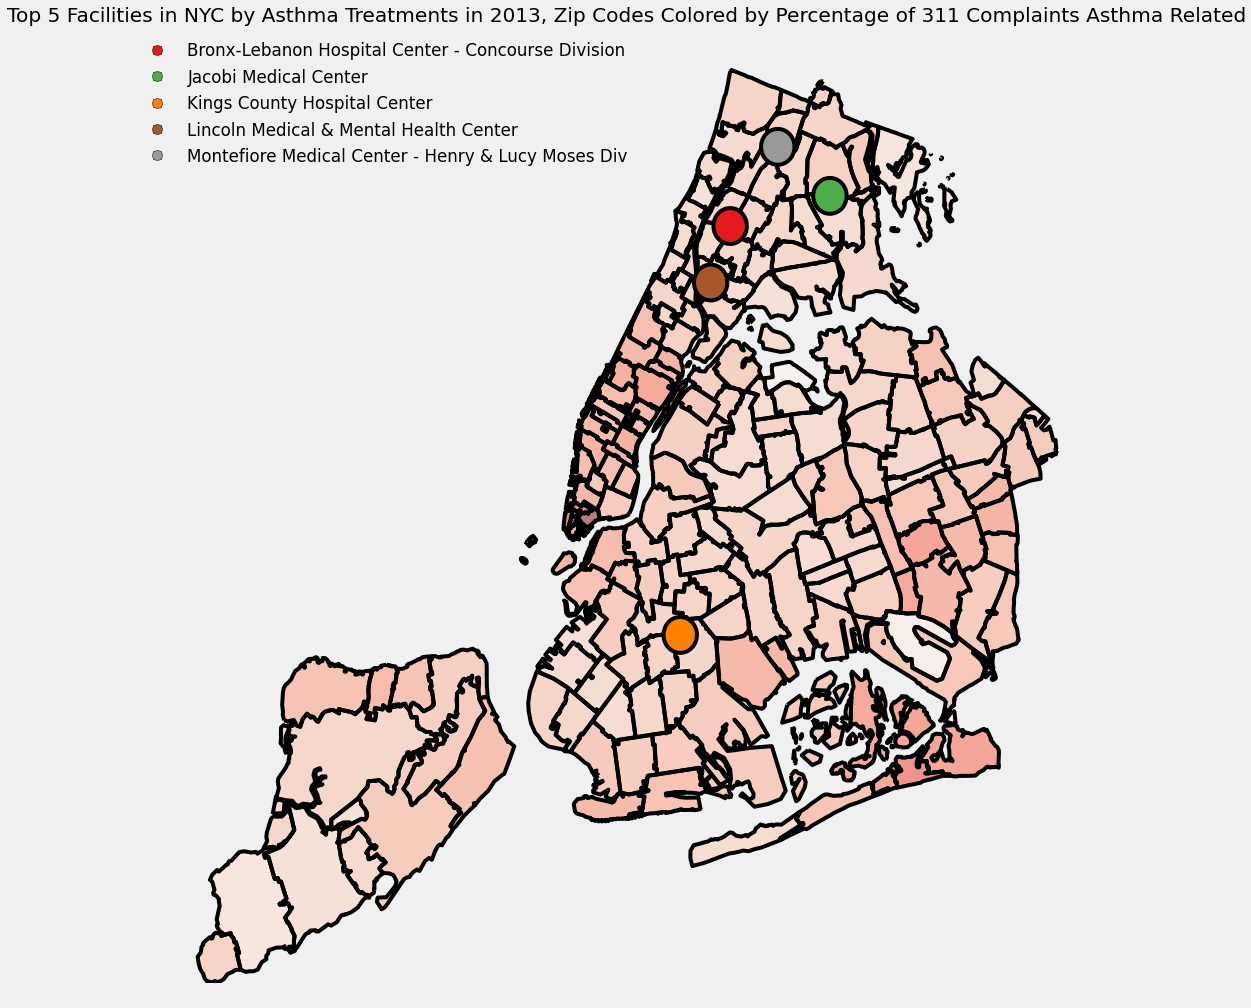

In [15]:
# Plot
figure, ax = pl.subplots(figsize=(16,16))

# Plot on separate axes.  For some reason I couldn't get the circles to show up
# above the zip codes any other way.
ax2 = ax.twinx()

# Plot
top311.plot(axes=ax2, column='facility_name', categorical=True, legend=True, alpha=1)
zipcodes311.plot(axes=ax, column='total_r',colormap='Reds')

# Fix scale
ax2.set_ylim(ax.get_ylim())

# Title and remove grid lines
ax.set_title('Top 5 Facilities in NYC by Asthma Treatments in 2013, Zip Codes Colored by Percentage of 311 Complaints Asthma Related')
ax.axis('off')
ax2.axis('off')

The locations of the 5 facilities in NYC to have the most asthma patients in 2013. Zipcodes are colored from white to red based on the percentage of 311 complaints in that zipcode that are related to asthma and environmental conditions for 2010-2013.

# Task 6

In [16]:
data = {
    'count': top311['count'],
    'highway_length': top311['highway_length'],
    'a': top311['2012_r'],
    'b': top311['2013_r']
}

# Standardize Data
for key in data:
    data[key] = (data[key] - data[key].mean()) / data[key].std()

mod = smf.ols(formula='count ~ highway_length + a + b', data = data).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     13.40
Date:                Thu, 17 Dec 2015   Prob (F-statistic):              0.198
Time:                        21:46:39   Log-Likelihood:                 2.7597
No. Observations:                   5   AIC:                             2.481
Df Residuals:                       1   BIC:                            0.9183
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept      -8.327e-17      0.139  -5.98e

c:\Users\Jeremy\Anaconda\lib\site-packages\statsmodels\stats\stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


I used a model containing the highway length, and percentage of 311 complaints possibly related to asthma from both 2013 and 2012 (because environmental causes of asthma may take time to develop, including a lag of a year could be good).

At first glance the model looks good.  An R^2 of .976!  But this is just because I'm using 4 variables (the three above plus the intercept) to predict 5 values, so it's of course going to fit well.

None of the variables are non-zero to a .05 significance level, so based on this model we can't say that either highway length or 311 complaints are a predictor of asthma cases at hospitals within the same zipcode.

# Task 7

In [17]:
# Get the same columns for the whole set of zipcodes
all_data = {
    'highway_length': zipcodes311['highway_length'],
    'a': zipcodes311['2012_r'],
    'b': zipcodes311['2013_r']
}

# Get the predicted values from the OLS model
predictions = mod.predict(all_data)

# Standardize Data
for key in all_data:
    all_data[key] = (all_data[key] - all_data[key].mean()) / all_data[key].std()
    
# Multiply by Coefficients
all_data['highway_length'] *= mod.params[1]
all_data['a'] *= mod.params[2]
all_data['b'] *= mod.params[3]

In [18]:
# Get the data as a matrix for clustering
matrix = pd.DataFrame(all_data).as_matrix()

In [19]:
# Run Kmeans clustering and assign the labels 
# Choose three clusters because when clustering with more than
# 3, very few zipcodes are put into more than the 3 primary ones.
num_clusters = 3
res = sklearn.cluster.KMeans(n_clusters=num_clusters).fit(matrix)

In [20]:
# Get the predicted average value for each of the clusters
# so we can make sense of them.  i.e whether they should be
# seen as high or low risk clusters.
# Then relabel the clusters

labels = res.labels_ + 100
#print labels
clusters = []
for i in range(100,num_clusters+100):
    clusters.append((i, predictions[labels == i].mean()))
    
clusters = sorted(clusters, key=lambda x: x[1], reverse=True)
#print clusters

# Relabel the clusters in order
for i in range(len(clusters)):
    labels[labels == clusters[i][0]] = i
    
labels = labels.astype(unicode)
labels[labels == '0'] = '0 - Highest'
labels[labels == str(num_clusters - 1)] = '%s - Lowest' % (num_clusters - 1)
zipcodes311['label'] = labels

(900000.0, 1080000.0, 120000.0, 280000.0)

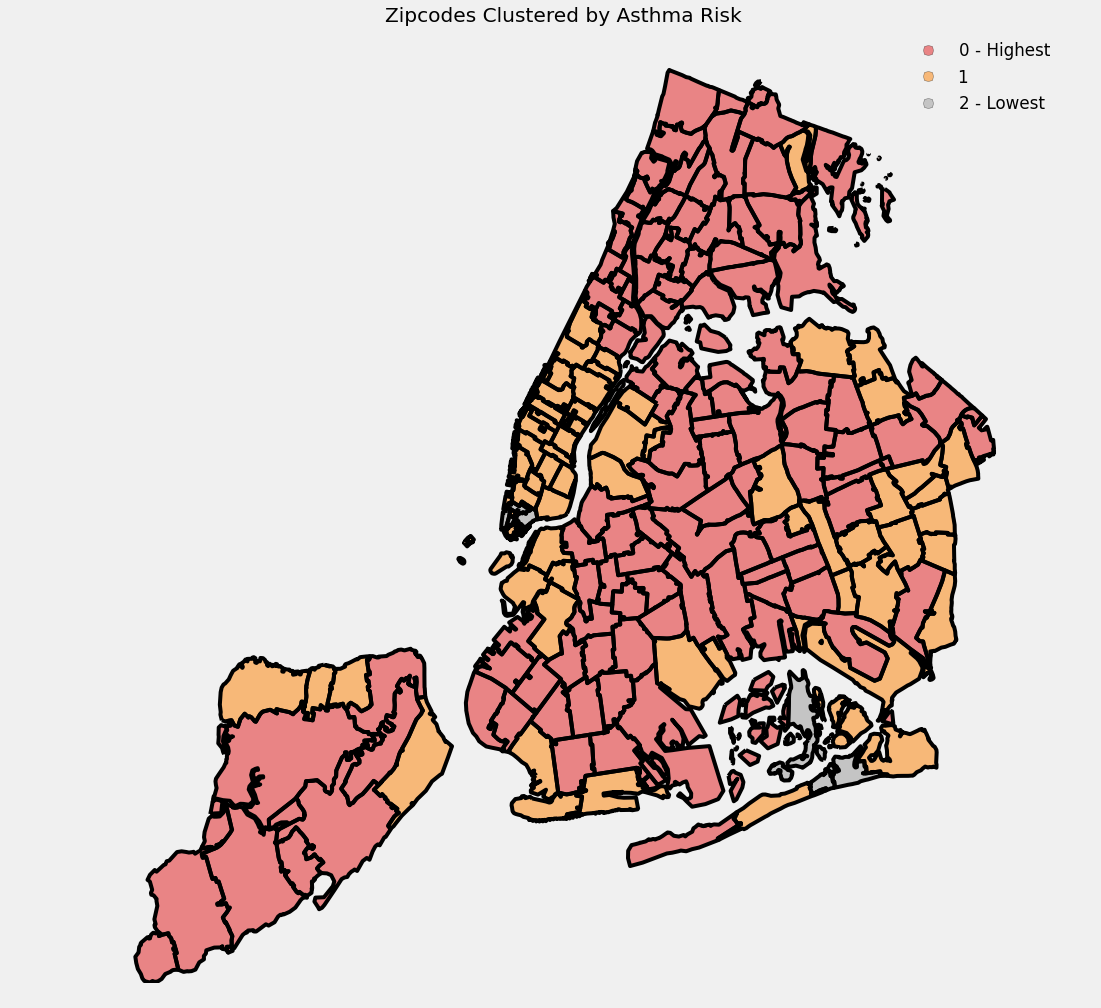

In [21]:
# Plot
figure, ax = pl.subplots(figsize=(16,16))

zipcodes311.plot(axes=ax, column='label',categorical=True, legend=True)

# Title and remove grid lines
ax.set_title('Zipcodes Clustered by Asthma Risk')
ax.axis('off')

Zip codes clustered by risk of asthma with 3 clusters.  The highest risk cluster covers most of central and eastern Brooklyn, Queens, Southern Staten Island, Northern Manhattan and the Bronx.  The medium risk cluster Covers centeral Manhattan, Downtown and Southern Brooklyn, Eastern Queens, and North Staten Island.  The lowest risk and smallest cluster is just the southern tip of Manhattan and some places in Rockaway.

# Discussion

There appear to be only about three meaningful clusters.  Adding more to the kmeans algorithm doesn't add any more large sized clusters.  The highest risk cluster covers most of the city, while Midtown, Downtown Brooklyn, Eastern Queens and North Staten Island are seen as lower risk.  And a small cluster including Downtown Manhattan, and parts of Rockaway are the lowest.

The first potential flaw is that we are using the zipcode of the treatment facility, but what we _really_ what we want to know is the zipcode of the patient and not the zipcode of where they were treated, which is of course not available in this dataset since it's been scrubbed of personal information.  But there could be any number of reasons why the location of the facility isn't a good indicator of the asthma risk of that location - for instance, a particular facility may specialize in asthma.

We also only used the top 5 facilities to build the model, while we could have included all of them to reduce the potential noise.  Using only the top 5 also omitted having any data in the model about Manhattan, Queens and Staten Island, since 4 of the top 5 are in the Bronx and the last is in Brooklyn.  And while that could be meaningful, that so many of them are in the Bronx, it also could overvalue features that just happen to also be in the Bronx.  For example, there is a lot of highway in the Bronx, but there is also a lot of highway in Queens, yet none of the top 5 facilities.  Therefore highway length may be over valued in the model since Queens was omitted while building it.